In [1]:
import random
import cv2
import numpy as np
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn.functional as F
import os
import torch.nn as nn
import functools
from torch.nn import init
from torch.utils import data
from medpy.metric.binary import recall,specificity,hd95
import sys
from dataset_brain import Dataset_gan, Dataset_gan_T, Dataset_gan_F
from loss import dice_loss,dice_score
from subprocess import call
from model import netD, define_G, Unet
from utils import label2onehot,classification_loss,gradient_penalty,seed_torch,update_lr
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import SimpleITK as sitk 
from tqdm import tqdm
import glob 
from scipy.ndimage import zoom
import re
import matplotlib.colors as colors
from nibabel.testing import data_path
import math
import time
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

In [2]:
file_path_flair=glob.glob('./dataset/**/*_flair.nii',recursive=True)
file_path_seg=glob.glob('./dataset/**/*_seg.nii',recursive=True)
file_path_t1=glob.glob('./dataset/**/*_t1.nii',recursive=True)
file_path_t1ce=glob.glob('./dataset/**/*_t1ce.nii',recursive=True)
file_path_t2=glob.glob('./dataset/**/*_t2.nii',recursive=True)
data_path = []
data_path.extend(file_path_flair)
data_path.extend(file_path_seg)
data_path.extend(file_path_t1)
data_path.extend(file_path_t1ce)
data_path.extend(file_path_t2)

In [3]:
random.seed(10)
split_n=random.sample(range(1050),1)

test_path=[data_path[i] for i in split_n]
train_path=[data_path[i] for i in split_n]
gan_path=[data_path[i] for i in split_n]

In [108]:
flair,t1,t1ce,t2,seg=[],[],[],[],[]
tumor,nontumor,total=0,0,0

for i in train_path:
    flair_path=i
    t1_path=i.replace('_flair','_t1')
    t1ce_path=i.replace('_flair','_t1ce')
    t2_path=i.replace('_flair','_t2')
    label_path=i.replace('_flair','_seg')

    img_flair=nib.load(flair_path).get_data()
    img_t1=nib.load(t1_path).get_data()
    img_t1ce=nib.load(t1ce_path).get_data()
    img_t2=nib.load(t2_path).get_data()
    label=nib.load(label_path).get_data()
    
    label[label!=0]=1
    
    img_flair_=img_flair.copy()
    img_flair_[img_flair_!=0]=1
    
    img_t1_=img_t1.copy()
    img_t1_[img_t1_!=0]=1
    
    img_t1ce_=img_t1ce.copy()
    img_t1ce_[img_t1ce_!=0]=1
    
    img_t2_=img_t2.copy()
    img_t2_[img_t2_!=0]=1
    
    for j in range(154,-1,-1):
        a=label[:,:,j].sum()
        b=img_flair_[:,:,j].sum()
        c=img_t1_[:,:,j].sum()
        d=img_t1ce_[:,:,j].sum()
        e=img_t2_[:,:,j].sum()
        threshold = 2000
        if b>threshold and c>threshold and d>threshold and e>threshold:

            img_slice=img_flair[:,:,j]
            mm0=cv2.resize(img_slice,(169,169),interpolation=cv2.INTER_AREA)
            TARGET=mm0
            #[22:102,26:106]
            mm0=mm0/mm0.max()
            flair.append(mm0)

            img_slice=label[:,:,j]
            mm0=cv2.resize(img_slice,(169,169),interpolation=cv2.INTER_AREA)
            mm0=mm0[20:148,27:155]
            mm0[mm0>=0.5]=1.
            mm0[mm0!=1]=0.
            seg.append(mm0)
            
            total+=1
            if a>50:
                tumor+=1
            elif a==0:
                nontumor+=1  

np.save('./npy_train/train_flair.npy',flair)
np.save('./npy_train/train_t1.npy',t1)
np.save('./npy_train/train_t1ce.npy',t1ce)
np.save('./npy_train/train_t2.npy',t2)
np.save('./npy_train/train_seg.npy',seg)

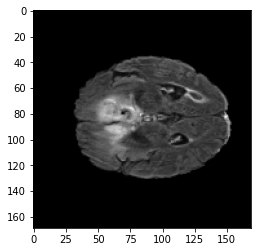

In [112]:
x = flair[70]
plt.imshow(x,cmap="gray")

In [ ]:
x = seg[70]
plt.imshow(x,cmap="gray")

(128, 128)


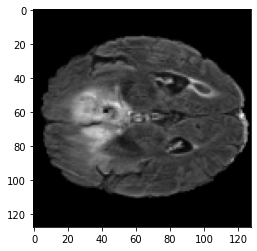

In [113]:
x = flair[70]
x=x[20:148,27:155]
plt.imshow(x,cmap="gray")
print(np.shape(x))
plt.show()